In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from zuko.flows import UnconditionalDistribution
from torch.distributions import Cauchy, Normal, Laplace, Bernoulli, Uniform
from causalflows.flows import CausalFlow
import copy
from causal_cocycle.ssvkernel import ssvkernel
import numpy as np
from scipy.stats import betaprime, norm
from architectures import get_nsf_transforms

In [2]:
# ---------------- helper: draw |NBP(0.1,0.1)| ---------
def draw_abs_nbp(size):
    """
    |NBP(0.1,0.1)|  where  NB P  is  Normal–Beta-Prime:
      τ   ~ BetaPrime(0.1, 0.1)
      V|τ ~ N(0, τ)
      return |V|
    """
    τ   = betaprime.rvs(0.1, 0.1, size=size)
    v   = norm.rvs(scale=np.sqrt(τ))
    return np.abs(v)

class MixedTails:

    def __init__(self,):
        return

    def sample(self, size):
        b = Bernoulli(1/2).sample(size)
        u1 = Normal(0,1).sample(size).abs()
        u2 = torch.tensor(draw_abs_nbp(size))
        return u1*b - u2*(1-b)
    

# ── Data ─────────────────────────────────────────────────────
seed = 0
torch.manual_seed(seed)
N_train = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Y0 = MixedTails().sample((N_train,1)).to(device)
Y1 = 2*Y0

# ── Build base and transforms ───────────────────────────────
d = 1   # dim(Y)
# two bases (here both Gaussian; you could swap in Laplace etc.)
base0 = UnconditionalDistribution(Laplace, loc=torch.zeros(d), scale=torch.ones(d), buffer=True)
base1 = UnconditionalDistribution(Laplace, loc=torch.zeros(d), scale=torch.ones(d), buffer=True)

# transform
nsf0,nsf1 = get_nsf_transforms()

# instantiate two flows
flow0 = CausalFlow(transform=nsf0, base=base0).to(device)
flow1 = copy.deepcopy(CausalFlow(transform=nsf1, base=base1).to(device))

In [3]:
from torch.optim import Adam

# common hyper‐params
lr = 1e-2
batch_size = 128
num_epochs = 1000

# ── DataLoaders ──────────────────────────────────────────────
loader0 = DataLoader(TensorDataset(Y0), batch_size=batch_size, shuffle=True)
loader1 = DataLoader(TensorDataset(Y1), batch_size=batch_size, shuffle=True)

# ── Optimizers ───────────────────────────────────────────────
opt0 = Adam(flow0.parameters(), lr=lr)
opt1 = Adam(flow1.parameters(), lr=lr)

# ── 3) Training loops ─────────────────────────────────────────────────────────
for epoch in range(1, num_epochs+1):
    # train flow0 on Y0
    running0 = 0.0
    for (y_batch,) in loader0:
        y_batch = y_batch.to(device)
        dist0 = flow0()                           # returns a Distribution over Y
        loss0 = -dist0.log_prob(y_batch).mean()   # negative log-likelihood
        opt0.zero_grad()
        loss0.backward()
        opt0.step()
        running0 += loss0.item() * y_batch.size(0)
        
    # train flow1 on Y1
    running1 = 0.0
    for (y_batch,) in loader1:
        y_batch = y_batch.to(device)
        dist1 = flow1()
        loss1 = -dist1.log_prob(y_batch).mean()
        opt1.zero_grad()
        loss1.backward()
        opt1.step()
        running1 += loss1.item() * y_batch.size(0)

    if epoch % 50 == 0 or epoch == 1:
        print(f"Epoch {epoch:4d} | flow0 NLL = {running0/N_train:.3f} | flow1 NLL = {running1/N_train:.3f}")


Epoch    1 | flow0 NLL = 186461436748.509 | flow1 NLL = 104214680117.109
Epoch   50 | flow0 NLL = 37680469055.030 | flow1 NLL = 23771020565.946
Epoch  100 | flow0 NLL = 16922744400.125 | flow1 NLL = 11606498251.937
Epoch  150 | flow0 NLL = 10192701509.518 | flow1 NLL = 7188931205.447
Epoch  200 | flow0 NLL = 6932996686.499 | flow1 NLL = 4960091217.799
Epoch  250 | flow0 NLL = 5079968459.488 | flow1 NLL = 3647163330.136
Epoch  300 | flow0 NLL = 3869014901.071 | flow1 NLL = 2799005094.347
Epoch  350 | flow0 NLL = 3029273344.224 | flow1 NLL = 2212103783.016
Epoch  400 | flow0 NLL = 2411661300.926 | flow1 NLL = 1784123393.431
Epoch  450 | flow0 NLL = 1961686393.367 | flow1 NLL = 1453874534.384
Epoch  500 | flow0 NLL = 1616846397.044 | flow1 NLL = 1196904329.929
Epoch  550 | flow0 NLL = 1334070976.889 | flow1 NLL = 994785064.611
Epoch  600 | flow0 NLL = 1114336519.858 | flow1 NLL = 832379841.374
Epoch  650 | flow0 NLL = 936705479.530 | flow1 NLL = 703683536.457
Epoch  700 | flow0 NLL = 7891

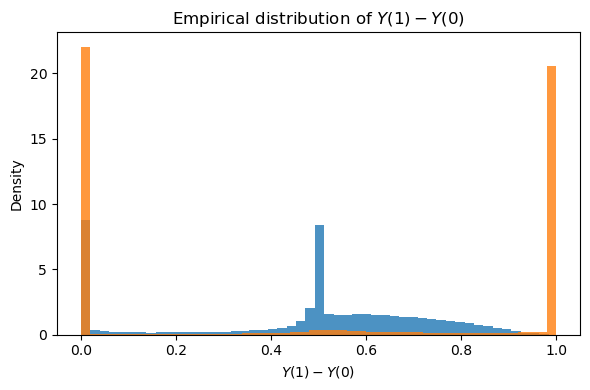

In [4]:
# ── 4) Paired sampling via reseeding ──────────────────────────────────────────
torch.manual_seed(0)
N_effect = 100000
delta = []
# Sample N_effect from flow0
dist0 = flow0()
with torch.no_grad():
    u = dist0.base.sample((N_effect,1))
    Y0_eff = dist0.transform.inv(u).cpu().squeeze()

# Reset seed so flow1 draws the exact same base noise
dist1 = flow1()
with torch.no_grad():
    Y1_eff = dist1.transform.inv(u).cpu().squeeze()

delta = (Y1_eff - Y0_eff)
B = Bernoulli(0.5).sample((N_effect,))
#true_delta = -cauchy0.sample((N_effect,)).to(device).abs()*B + normal0.sample((N_effect,)).to(device).abs()*(1-B)
Y0 = MixedTails().sample((N_effect,)).to(device)
Y1 = Y0*2
true_delta = Y1-Y0

def t(x):
    return torch.sigmoid(x)
    #return torch.log(1+x.abs())*torch.sign(x)


# ── 5) Plot empirical histogram of ΔY ────────────────────────────────────────
plt.figure(figsize=(6,4))
plt.hist(t(true_delta), bins=50, density=True, alpha=0.8)
plt.hist(t(delta), bins=50, density=True, alpha=0.8)
plt.title("Empirical distribution of $Y(1)-Y(0)$")
plt.xlabel("$Y(1)-Y(0)$")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

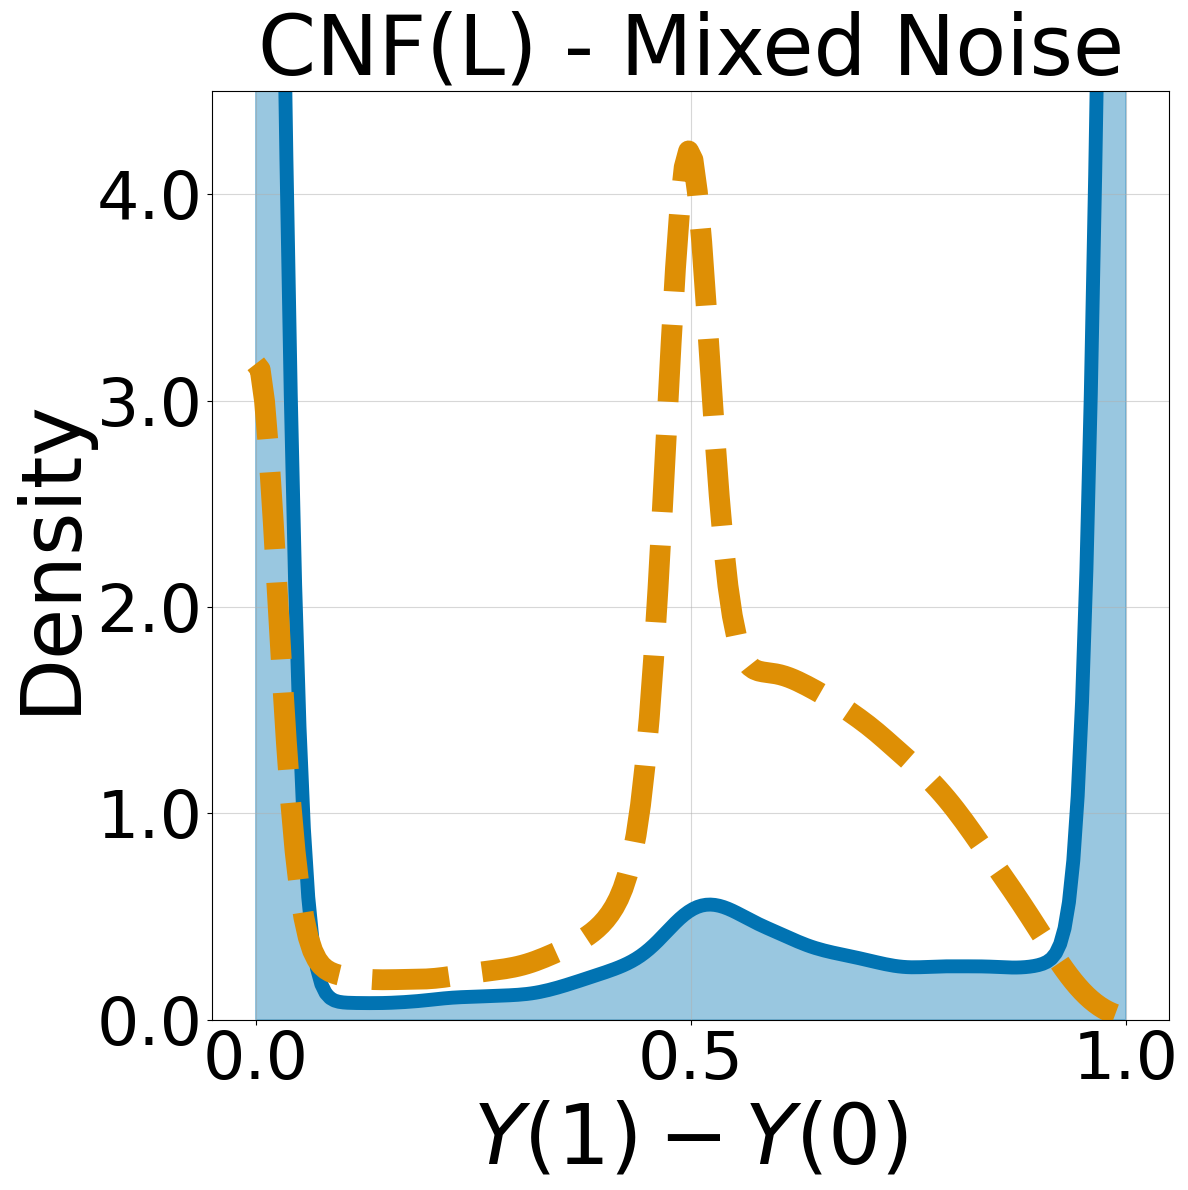

In [5]:
# ---------- plot ----------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from scipy.stats import norm                  # for the true density

# ---------- aesthetics (unchanged) ----------
plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
})
sns.set_style("whitegrid")
col_data, col_true = sns.color_palette("colorblind", 2)

x_grid = np.linspace(0, 1, 200)
y_hat = ssvkernel(t(delta).numpy(), tin=x_grid, M=80, nbs=100, WinFunc='Gauss')[0]
y_true = ssvkernel(t(true_delta).numpy(), tin=x_grid, M=80, nbs=100, WinFunc='Gauss')[0]

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(x_grid, y_hat, color=col_data, lw=10, label="Estimated")
ax.fill_between(x_grid, 0, y_hat, color=col_data, alpha=0.4)
ax.plot(x_grid, y_true, color=col_true, lw=15, ls="--", label="True")
ax.set_ylim(0,4.5)
ax.set_xlabel(r"$Y(1) - Y(0)$", fontsize = 60)
ax.set_ylabel("Density", fontsize = 60)
ax.tick_params(axis='x', labelsize=48)  # or whatever size you want
ax.tick_params(axis='y', labelsize=48)  # or whatever size you want
ax.set_title(r"CNF(L) - Mixed Noise", fontsize=60)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
#ax.legend(frameon=False, fontsize=48)
ax.grid(alpha = 0.5)
fig.tight_layout()
fig.savefig("flow_misspec_mixed_l.png", bbox_inches="tight")
plt.show()